In [52]:
import os
from gpuutils import GpuUtils
GpuUtils.allocate(gpu_count=1, framework='keras')

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True) 

import pandas as pd
from tensorflow import keras
import numpy as np
np.set_printoptions(precision=3, suppress=True)
from matplotlib import pyplot as plt, cm
import seaborn as sns
from radiotools import plthelpers as php
import matplotlib.colors as colors


GPU 1  will be allocated


In [2]:
df_test = pd.read_csv('/mnt/md0/aholmberg/data/raytrace_samples_random.csv')

In [4]:
sc_pos_r = df_test['source_pos_r'].to_numpy().astype(np.float32)
sc_pos_z = df_test['source_pos_z'].to_numpy().astype(np.float32)
ant_pos_z = df_test['antenna_pos_z'].to_numpy().astype(np.float32)
x_test = np.stack((sc_pos_r, sc_pos_z, ant_pos_z), axis=1)

travel_time = df_test['travel_time'].to_numpy().astype(np.float32)
path_length = df_test['path_length'].to_numpy().astype(np.float32)
launch = df_test['launch_angle'].to_numpy().astype(np.float32)
recieve = df_test['recieve_angle'].to_numpy().astype(np.float32)
y_test = np.stack((travel_time, path_length, launch, recieve), axis=1)


unique, index, count = np.unique(x_test, return_counts=True, return_index=True, axis=0)
print(unique, index, count)
print(np.unique(count, return_counts=True))
x_test[index[count == 1], :]
x_new_test = np.delete(x_test, index[count == 1], axis=0)
y_new_test = np.delete(y_test, index[count == 1], axis=0)
unique, index, count = np.unique(x_new_test, return_counts=True, return_index=True, axis=0)
print(unique, index, count)
print(np.unique(count, return_counts=True))


[[-1999.976  -998.204  -148.489]
 [-1999.971 -1442.621   -64.242]
 [-1999.951 -1724.919  -194.127]
 ...
 [   -1.016 -1645.266  -188.728]
 [   -1.014 -1570.393  -162.313]
 [   -1.013 -2660.319  -194.725]] [ 13521 121120  76422 ...  23815 197741  42865] [2 2 2 ... 2 2 2]
(array([1, 2]), array([    25, 113536]))
[[-1999.976  -998.204  -148.489]
 [-1999.971 -1442.621   -64.242]
 [-1999.951 -1724.919  -194.127]
 ...
 [   -1.016 -1645.266  -188.728]
 [   -1.014 -1570.393  -162.313]
 [   -1.013 -2660.319  -194.725]] [ 13520 121110  76414 ...  23812 197722  42860] [2 2 2 ... 2 2 2]
(array([2]), array([113536]))


In [5]:
name = 'multi-out-big'
model_path = '/mnt/md0/aholmberg/models/' + name
model = keras.models.load_model(model_path)
print(model.summary())
scaler_path_x = model_path + "-x-scaler.pkl"
scaler_path_y = model_path + "-y-scaler.pkl"
from pickle import load
scaler_x = load(open(scaler_path_x, 'rb'))
scaler_y = load(open(scaler_path_y, 'rb'))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         4096        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1024)         1049600     dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1024)         1049600     dense_1[0][0]                    
______________________________________________________________________________________________

In [6]:

x_test = x_new_test[0::2,:]

y_temp1_test  = y_new_test[0::2,:]
y_temp2_test  = y_new_test[1::2,:]
y_new_test = np.zeros((y_temp1_test.shape[0], 8))


for i in range(4):
    y_new_test[:,2*i] = y_temp1_test[:,i]
    y_new_test[:,2*i+1] = y_temp2_test[:,i]


y_test = y_new_test

norm_x_test = scaler_x.transform(x_test)
norm_y_test = scaler_y.transform(y_test)



In [7]:
temp1 = model(norm_x_test[:int(norm_x_test.shape[0]/2)])
temp2 = model(norm_x_test[int(norm_x_test.shape[0]/2):])
print(temp1[0].shape ,temp1[1].shape, temp1[2].shape,temp2[0].shape ,temp2[1].shape, temp2[2].shape)
y_test_pred = np.zeros((norm_y_test.shape))
#y_test_pred[:int(norm_x_test.shape[0]/2),:] = np.array(model(norm_x_test[:int(norm_x_test.shape[0]/2)]))#.numpy().flatten()
#y_test_pred[int(norm_x_test.shape[0]/2):,:] = np.array(model(norm_x_test[int(norm_x_test.shape[0]/2):]))#.numpy().flatten()

y_test_pred[:int(norm_x_test.shape[0]/2),:] = np.concatenate((temp1[0], temp1[1], temp1[2], temp1[3]), axis=1)
y_test_pred[int(norm_x_test.shape[0]/2):,:] = np.concatenate((temp2[0], temp2[1], temp2[2], temp2[3]), axis=1)
y_test_inv = scaler_y.inverse_transform(y_test_pred)

(56768, 2) (56768, 2) (56768, 2) (56768, 2) (56768, 2) (56768, 2)


In [9]:
diff = y_test - y_test_inv


sol = ['time_sol_1:', 
       'time_sol_2:',
       'length_sol_1:',
       'length_sol_2:',
       'launch_sol_1:',
       'launch_sol_2:',
       'recieve_sol_1:',
       'recieve_sol_2:']

for i in range(8):
    mean = np.mean(diff[:,i])
    std = np.std(diff[:,i])
    print(sol[i] + f' mean: {mean:.4f}  std: {std:.4f}')

time_sol_1: mean: 0.1873  std: 4.9371
time_sol_2: mean: 0.2576  std: 5.7794
length_sol_1: mean: 0.0022  std: 1.2036
length_sol_2: mean: 0.0269  std: 1.3660
launch_sol_1: mean: 0.0125  std: 0.2351
launch_sol_2: mean: 0.0046  std: 0.1508
recieve_sol_1: mean: -0.0006  std: 0.3610
recieve_sol_2: mean: -0.0058  std: 0.2663


In [10]:
l_bounds = [-2000, -2700, -200]
u_bounds = [-1, -1, -1]
vals = np.zeros((2650, 1950, 2, 8))
coords = np.zeros((2650, 1950, 2))

for i in range(-1,-2001+50, -1):
    for j in range(-1, -2701+50, -1):
        coords[2650 + j, -(i+1), :] = [i - 25, j - 25] # mid    point
        temp_r = np.logical_and(x_test[:,0] < i, x_test[:,0] > i - 50)
        temp_z = np.logical_and(x_test[:,1] < j, x_test[:,1] > j - 50)
        binned_vals = diff[np.logical_and(temp_r, temp_z), :]
        if binned_vals.shape[0] >= 10:
            vals[2650 + j, -(i+1), 0, :] = np.std(binned_vals, axis=0)
            vals[2650 + j, -(i+1), 1, :] = np.mean(binned_vals, axis=0)
        else:
            vals[2650 + j, -(i+1),: , :] = -100

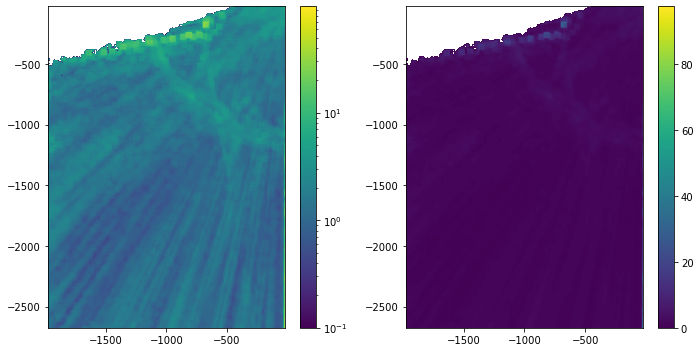

In [66]:
tmp = np.fliplr(vals[:,:,0,1])

cmap = cm.get_cmap('viridis')
cmap.set_under('white')
extent = [-1975, -26, -2675 , -26]


fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax_im1 = ax[0].imshow(tmp,
                  extent=extent,
                  norm=colors.LogNorm(vmin=0.1, vmax=tmp.max()),
                  cmap=cmap,
                  #vmin=0,
                  origin='lower',
                  aspect='equal')
fig.colorbar(ax_im1, ax=ax[0])

ax_im2 = ax[1].imshow(tmp,
                  extent=extent,
                  cmap=cmap,
                  vmin=0,
                  origin='lower',
                  aspect='equal')
fig.colorbar(ax_im2, ax=ax[1])
fig.tight_layout()

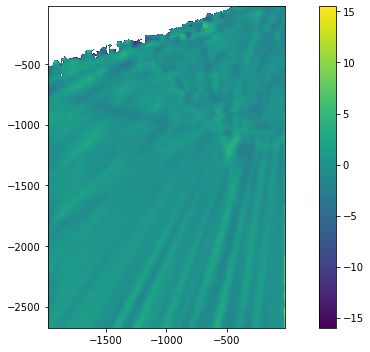

In [70]:
tmp = np.fliplr(vals[:,:,1,1])

cmap = cm.get_cmap('viridis')
cmap.set_under('white')
extent = [-1975, -26, -2675 , -26]


fig, ax = plt.subplots(figsize=(10, 5))

ax_im = ax.imshow(tmp,
                  extent=extent,
                  cmap=cmap,
                  vmin=-16,
                  origin='lower',
                  aspect='equal')
fig.colorbar(ax_im)
fig.tight_layout()